## Solve a heat equation on a domain defined by an .stl file
This example gives the code for solving the heat equation on a cornerplate.

In [1]:
import os
import torch
from torch._C import device
import pytorch_lightning as pl
import numpy as np
from torchphysics.problem.domain.domain3D import Polygon3D
from torchphysics.problem.domain.domain1D import Interval
from torchphysics.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from torchphysics.problem import (Variable,
                                    Setting)
from torchphysics.utils import laplacian, grad
from torchphysics import PINNModule
from torchphysics.models.fcn import SimpleFCN
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


We load the domain as a 3D volume from an .stl file. Afterwards we project it onto the xy-plane.

In [2]:
p = Polygon3D(file_name='cornerplate.stl')
p = p.project_on_plane(plane_origin=[0,0,0], plane_normal=[0,0,1])

The computed 2D polygon becomes the domain of x. We use D as an additional input to the network, just as we do in `heat_equation_D_variable.ipynb`. The behaviour of the code is also pretty similar to the other example.

In [3]:
# Create variables
x = Variable(name='x', order=2, domain=p,
             train_conditions={}, val_conditions={})
t = Variable(name='t', order=1, domain=Interval(0,3),
             train_conditions={}, val_conditions={})
D = Variable(name='D',
             order=0,
             domain=Interval(low_bound=10,
                             up_bound=20),
             train_conditions={},
             val_conditions={})

In [4]:
# Create boundary condition for x
norm = torch.nn.MSELoss()
def x_dirichlet_fun(input):
    return np.zeros_like(input['t'])
x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=500,
                                         data_plot_variables=('x', 't')))

The inital values are chosen such that they are non-zero on a third of the domain, and zero on the remaining parts. They are therefore non-smooth.

In [5]:
# Create boundary condition for t, i.e. initial values
def t_dirichlet_fun(input):
    temp = np.zeros((input['x'][:, :1].shape[0], 1), dtype=np.float32)
    for i in range(temp.shape[0]):
        if input['x'][i, 0] > 0 and input['x'][i, 1] > 0:
            temp[i][0] = 10*(np.cos(np.pi/40*(input['x'][i,0]-20))
                        *np.cos(np.pi/40*(input['x'][i,1]-20)))
    return temp
t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         norm=norm,
                                         dataset_size=500,
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x', 't')))

In [6]:
# Create pde condition 
def pde(u, input):
    return grad(u, input['t']) - input['D']*laplacian(u, input['x'])
train_cond = DiffEqCondition(pde=pde,
                             norm=norm,
                             dataset_size=2000,
                             data_plot_variables=('x', 't'))

In [7]:
# Put everything together
from torchphysics.utils.plot import Plotter

setup = Setting(variables=(x, t, D),
                train_conditions={'pde': train_cond},
                val_conditions={},
                n_iterations=1000)

plotter = Plotter(plot_variables=setup.variables['x'],
                  points=400,
                  dic_for_other_variables={'t': 1.0, 'D': 15.0},
                  all_variables=setup.variables,
                  log_interval=10)

model = SimpleFCN(input_dim=4, width=50)

solver = PINNModule(model=model,
                    optimizer=torch.optim.Adam,
                    lr=1e-3)

In [8]:
# Start training
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     max_epochs=20,
                     logger=False,
                     limit_val_batches=0.0,
                     num_sanity_val_steps=0)
trainer.fit(solver)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 8.0 K 
------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
Epoch 0:   1%|          | 12/1001 [00:14<19:18,  1.17s/it, loss=9.39, v_num=10]

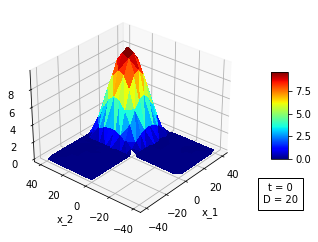

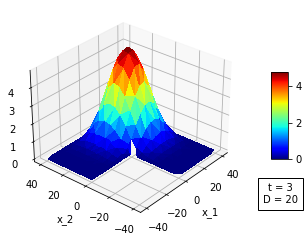

In [17]:
# Plot the solution
from torchphysics.utils.plot import _plot
fig = _plot(model=model, plot_variables=x, points=200, angle=[30, 220], 
            dic_for_other_variables={'t' : 0, 'D' : 20})
fig = _plot(model=model, plot_variables=x, points=200, angle=[30, 220], 
            dic_for_other_variables={'t' : 3, 'D' : 20})

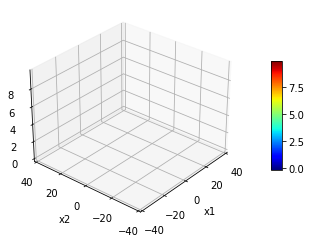

In [19]:
# Create a animation of the solution
from torchphysics.utils.animation import animation
fig, ani = animation(model=model, plot_variables=x, domain_points=200, angle=[30, 220], 
                animation_variable=t, frame_number=100, dic_for_other_variables={'D' : 10})
#ani.save('heat_equation_D=10.gif')
